# Intelligent System for Detecting and Classifying Solar Module Defects


## Section I: Importing Necessary Packages & Defining Functions

### Typically I would use a function file for all functions being created and used, but for the convenience of having all of them in one location they are within the notebook

In [1]:
import os
import cv2
import keras
import json
import flyr

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from matplotlib.image import imread
from keras.models import Sequential
from keras.layers import Dense, Convolution1D, Convolution2D, MaxPool2D, MaxPool1D, Flatten, Dropout, Input, BatchNormalization, Activation, Embedding, Add, LSTM, SimpleRNN
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.optimizers import RMSprop
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC
from skimage.color import label2rgb
from skimage.measure import label, regionprops
from skimage.draw import polygon2mask
from mpl_toolkits.axes_grid1 import make_axes_locatable
from re import findall
from os.path import join, basename
from glob import glob

In [2]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap='Pastel1'):
    plt.figure(figsize=(9,9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 15)
    plt.colorbar()
    tick_marks = np.arange(8)
    plt.xticks(tick_marks, ["1", "2", "3", "4", "5", "6", "7","8"], rotation=45, size = 10)
    plt.yticks(tick_marks, ["1", "2", "3", "4", "5", "6", "7","8"], size = 10)
    plt.tight_layout()
    plt.ylabel('Actual label', size = 15)
    plt.xlabel('Predicted label', size = 15)
    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
            
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'], linewidth=8, c='black')
    plt.plot(history.history['val_accuracy'], linewidth=8, c='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.savefig('model_acc_4.png', bbox_inches='tight')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'], linewidth=8, c='black')
    plt.plot(history.history['val_loss'], linewidth=8, c='red')
    plt.savefig('model_loss_4.png', bbox_inches='tight')
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction) 

def get_annotation_data(annotation_path: str):
    with open(annotation_path, 'r', encoding='utf-8') as annotation_file:
        annotation_data = json.load(annotation_file)
    return pd.DataFrame(annotation_data['instances'])

def get_image_name(file_path: str):
    file_name = basename(file_path)
    return findall('[0-9]+', file_name)[-1]

def get_mask_from_annotation_data(annotation_data, shape=(512, 640)):
    mask = np.zeros(shape, dtype='int16')
    for index, corner_points in enumerate(annotation_data['corners'], start=1):
        polygon = np.array([
            [coords['y'], coords['x']] for coords in corner_points
        ])
        instance_mask = polygon2mask(shape, polygon)
        mask[instance_mask] = index
    return mask

def get_center_from_annotation_data(annotation_data):
    return np.array([
        [coords['x'], coords['y']] for coords in annotation_data['center']
    ])

def get_defect_module_label(index: int):
    if index == 1:
        return 1, None
    elif index == 2:
        return 6, None
    elif index == 3:
        return 7, None
    elif index == 4:
        return 35, None
    elif index == 5:
        return 17, None
    elif index == 6:
        return 21, None
    elif index == 7:
        return 15, None
    elif index == 8:
        return 10, None
    return 1, 2

def convert_to_binary(x):
    x = 'Anomaly' if x != 'No-Anomaly' else x
    return x

## Section II: Array Images
### This portion reads in images of an array, thermal images, thermal camera metadata, and annotations to be able to highlight defective modules in an array

In [3]:
#define paths for images and their accompanying annotations
DATA_PATH = './'
images_paths = glob(join(DATA_PATH, 'images_uav/*.jpg'))
images_paths = sorted(images_paths, key=get_image_name)

annotations_paths = glob(join(DATA_PATH, 'annotations/*.json'))
annotations_paths = sorted(annotations_paths, key=get_image_name)

get_annotation_data(annotations_paths[0]).head(5)

,corners,center,defected_module
0,"[{'x': 244.83972010293138, 'y': -0.13906923759...","{'x': 216.7573906849453, 'y': 47.692876107299796}",False
1,"[{'x': 301.11259600795165, 'y': 0.293799038594...","{'x': 273.78778607330236, 'y': 48.666829728732...",False
2,"[{'x': 357.60190605106817, 'y': 3.756745248134...","{'x': 329.6277937021302, 'y': 49.91132602278617}",False
3,"[{'x': 410.84470402274115, 'y': 6.786823181481...","{'x': 384.0609794333325, 'y': 52.34621007636878}",False
4,"[{'x': 410.84470402274115, 'y': -0.35550337569...","{'x': 384.3315221059528, 'y': 2.1334892124122846}",False


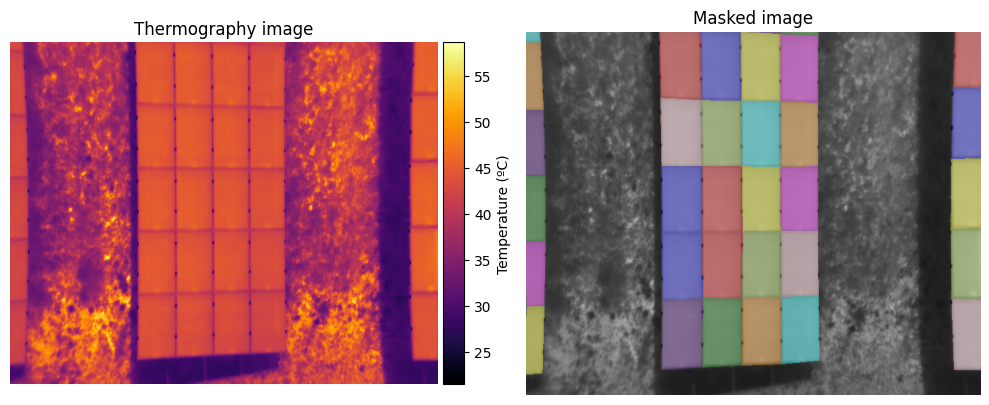

In [4]:
# combine image and annotation paths
annotation_path, image_path = next(zip(annotations_paths, images_paths))

#the flyr package was created to unpack metadata from images taken by a FLIR thermal camera
thermogram = flyr.unpack(image_path)

# Get mask from annotation file
annotation_data = get_annotation_data(annotation_path)
mask = get_mask_from_annotation_data(annotation_data)
masked_image = label2rgb(mask, thermogram.render(palette='grayscale'))

#show image and mask extracted from annotations and metadata 
#this shows that this array has no thermal defects (right) and where each individual module is (left)
_, ax = plt.subplots(1, 2, figsize=(10,5))    
im = ax[0].imshow(thermogram.celsius, cmap='inferno')
cax = make_axes_locatable(ax[0]).append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, values=np.unique(thermogram.celsius), label='Temperature (ºC)')    
ax[0].set_title('Thermography image')
ax[0].set_axis_off()
ax[1].imshow(masked_image)
ax[1].set_title('Masked image')
ax[1].set_axis_off()
plt.tight_layout()
plt.show()

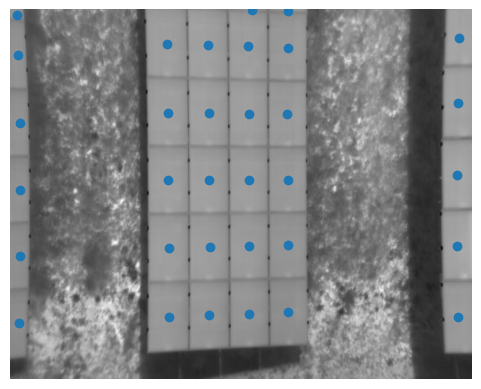

In [5]:
#the annotations & metadata also contains enough info where we can get the centers of each module

annotation_path, image_path = next(zip(annotations_paths, images_paths))
thermogram = flyr.unpack(image_path)
annotation_data = get_annotation_data(annotation_path)
centers = get_center_from_annotation_data(annotation_data)

plt.imshow(thermogram.render(palette='grayscale'))
plt.scatter(centers[:, 0], centers[:, 1])
plt.axis('off')
plt.show()

In [6]:
#this will show us how many defective modules are present in the dataset
defected_modules = {}
annotation_generator = map(get_annotation_data, annotations_paths)
for index, annotation_data in enumerate(annotation_generator, start=1):
    defected_modules[index] = annotation_data['defected_module'].sum()  

print(f'Number of defected modules: {sum(defected_modules.values())}')

Number of defected modules: 26


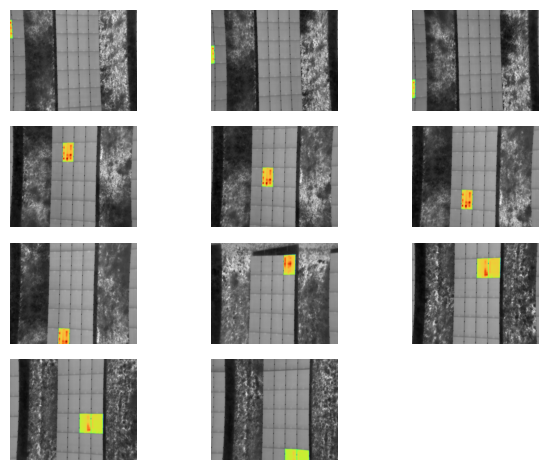

In [7]:
#we can plot examples of defective modules with the thermal overlays to see what the defect looks like and exactly what module its on
cell_mulit_defect_image_path = images_paths[27:30] + images_paths[39:43] + [images_paths[65]] + images_paths[82:85]
cell_multi_defect_annotations_path = annotations_paths[27:30] + annotations_paths[39:43] + [annotations_paths[65]] + annotations_paths[82:85]
generator = zip(cell_mulit_defect_image_path, cell_multi_defect_annotations_path)

for index, (image_path, annotation_path) in enumerate(generator, start=1):
    label_mask = get_mask_from_annotation_data(get_annotation_data(annotation_path))
    defect_label = get_defect_module_label(index)
    defect_binary_mask = np.where((label_mask == defect_label[0]) | (label_mask == defect_label[1]),True, False)
    thermal_defect = flyr.unpack(image_path).render_pil(mask=defect_binary_mask,unit='celsius',palette='turbo')
    
    plt.subplot(4, 3, index)
    plt.imshow(thermal_defect)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Future work would include actually segmenting the images instead of just highlighting the individual module in an array image. This was not done since the annotations for these images on show defective/non-defective

## Section III: Classification of Individual Module Thermal Images

In [8]:
#we can read in the data
DATA_PATH = './'
METADATA_PATH = './module_metadata.json'
df = pd.read_json(METADATA_PATH, orient='index').sort_index()
df['image_filepath'] = df.image_filepath.apply(lambda x: os.path.join(DATA_PATH, x))
df.head(5)

,image_filepath,anomaly_class
0,./images/0.jpg,Offline-Module
1,./images/1.jpg,Offline-Module
2,./images/2.jpg,Offline-Module
3,./images/3.jpg,Offline-Module
4,./images/4.jpg,Offline-Module


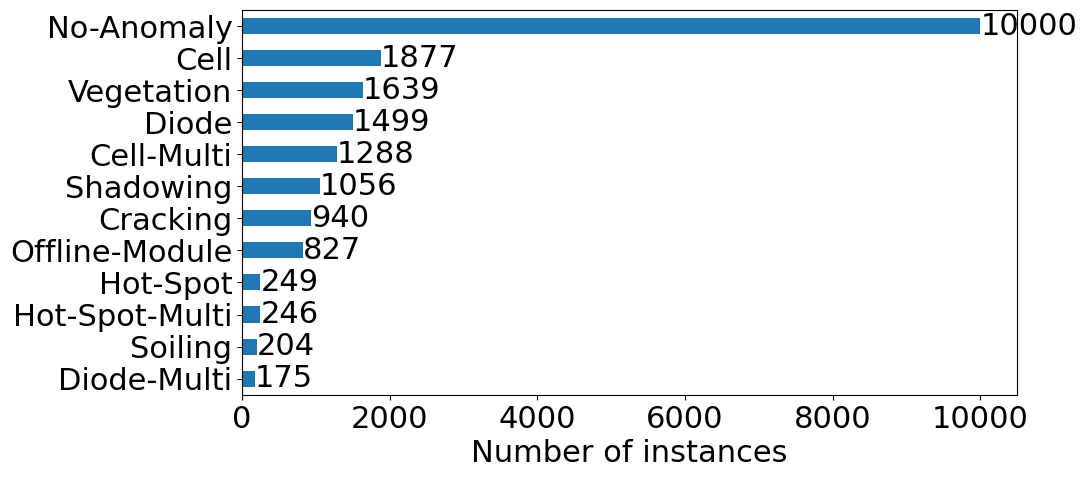

In [9]:
#show the current distribution of defects
plt.rcParams.update({'font.size': 22})
ax = df.anomaly_class.value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of instances')
plt.savefig('dist_org.png', bbox_inches='tight')
plt.show()

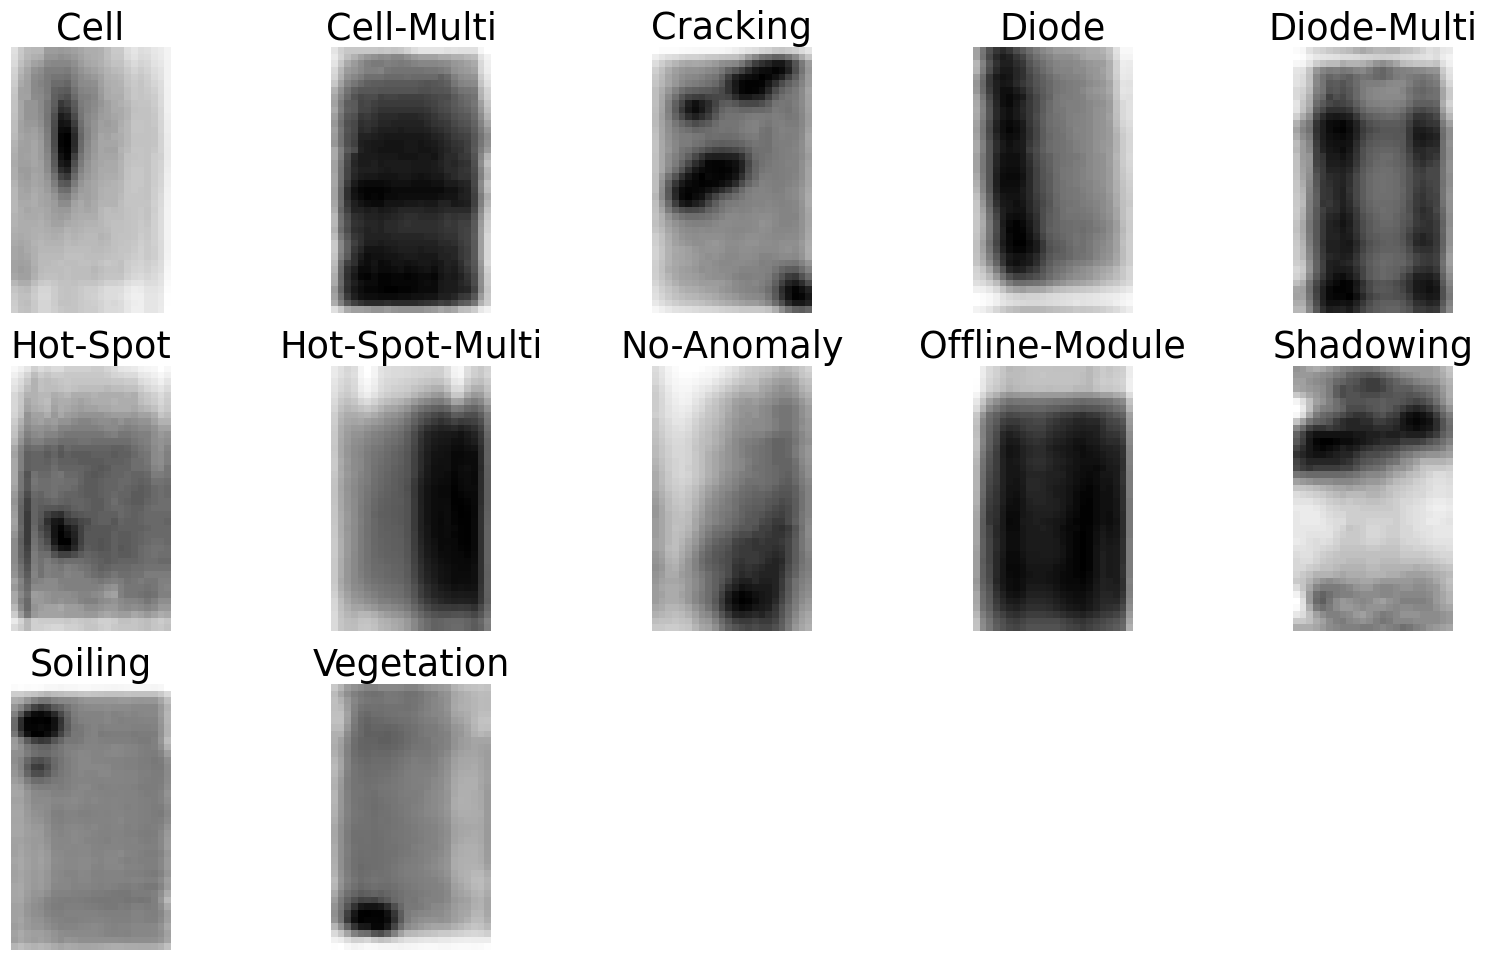

In [10]:
#show an example of each type of defect 
sample = df.groupby('anomaly_class').sample()

plt.figure(figsize=(20,20))
for i, (image_path, class_name) in enumerate(sample.values, start=1):
    image = cv2.imread(image_path, 0)
    plt.subplot(5, 5, i)
    plt.imshow(image, cmap='Greys')
    plt.title(class_name)
    plt.axis('off')
    
plt.savefig('defect_type.png', bbox_inches='tight')
plt.show()

In [11]:
#we will only investigate the classification of crystalline silicon pv modules, so these defects can be taken out
df = df.query('anomaly_class != ("Hot-Spot", "Hot-Spot-Multi")')

In [12]:
# resample the data so that there are equal amounts of each category
# two categories are left out: soiling & diode-multi for too few samples
df_1=df.loc[df['anomaly_class']=='Offline-Module']
df_2=df.loc[df['anomaly_class']=='Diode']
df_3=df.loc[df['anomaly_class']=='Shadowing']
df_4=df.loc[df['anomaly_class']=='Cell-Multi']
df_5=df.loc[df['anomaly_class']=='Cell']
df_6=df.loc[df['anomaly_class']=='Vegetation']
df_7=df.loc[df['anomaly_class']=='No-Anomaly']
df_8=df.loc[df['anomaly_class']=='Cracking']

df_1_upsample=resample(df_1,replace=True,n_samples=750,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=750,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=750,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=750,random_state=125)
df_5_upsample=resample(df_5,replace=True,n_samples=750,random_state=122)
df_6_upsample=resample(df_6,replace=True,n_samples=750,random_state=123)
df_7_upsample=resample(df_7,replace=True,n_samples=750,random_state=124)
df_8_upsample=resample(df_8,replace=True,n_samples=750,random_state=125)

#this is our rebalanced dataset for defects for c-Si modules only
crystal_df=pd.concat([df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample,df_6_upsample,df_7_upsample,df_8_upsample])

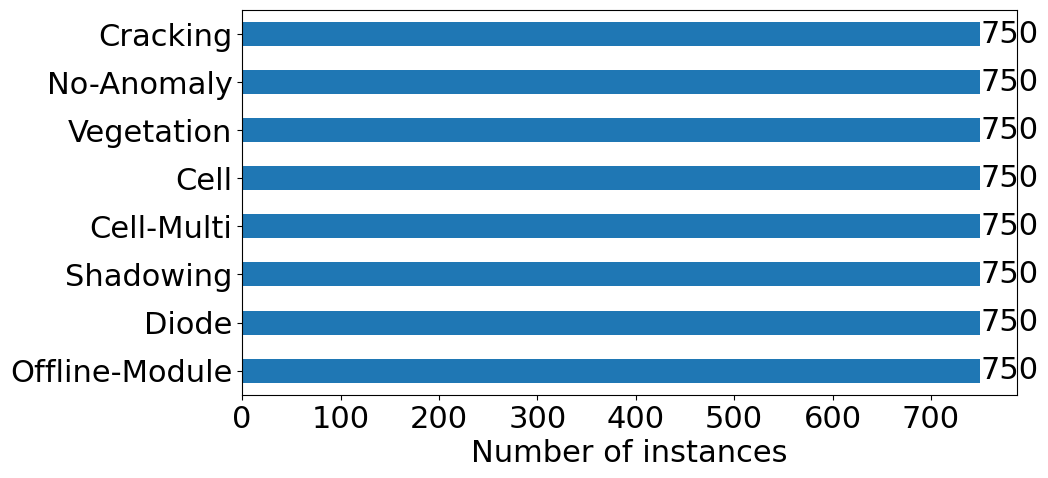

In [13]:
#show the newly distributed data
ax = crystal_df.anomaly_class.value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of instances')
plt.savefig('dist_fin.png', bbox_inches='tight')
plt.show()

In [14]:
#split the image into testing and training
x_train, x_test, y_train, y_test = train_test_split(crystal_df['image_filepath'], crystal_df['anomaly_class'], 
                                                    test_size=0.3, shuffle=True)#, stratify=crystal_df['anomaly_class'])

In [15]:
#converting image files into 2d arrays of numbers 
x_train_array = []
for image_path in x_train.iloc[0:13653]:
    image = imread(image_path)
    x_train_array.append(image)

x_test_array = []
for image_path in x_test.iloc[0:5852]:
    image = imread(image_path)
    x_test_array.append(image)

In [16]:
#turning the lists of arrays into a singular array
x_test_df = np.array(x_test_array)
x_train_df = np.array(x_train_array)

#turning the text labels into categorical variables
le = preprocessing.LabelEncoder()
le.fit(y_test)
y_test_cat = le.transform(y_test)
y_test_cat = to_categorical(y_test_cat)
le.fit(y_train)
y_train_cat = le.transform(y_train)
y_train_cat = to_categorical(y_train_cat)

In [17]:
#building the CNN model

cnn_model = Sequential()

cnn_model.add(Convolution2D(filters = 64, kernel_size = 6, activation='relu', padding = 'same', input_shape = (40,24, 1))) 
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3,3), strides = (2), padding = 'same'))

cnn_model.add(Convolution2D(filters = 64, kernel_size = 6, activation='relu', padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3,3), strides = (2), padding = 'same'))

cnn_model.add(Convolution2D( filters = 64, kernel_size = 6, activation='relu', padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3,3), strides = (2), padding = 'same'))

cnn_model.add(Flatten())
cnn_model.add(Dense(units = 64, activation='relu'))
cnn_model.add(Dense(units = 64, activation='relu'))
cnn_model.add(Dense(units = 8, activation='softmax'))

cnn_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 24, 64)        2368      
                                                                 
 batch_normalization (BatchN  (None, 40, 24, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 12, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 12, 64)        147520    
                                                                 
 batch_normalization_1 (Batc  (None, 20, 12, 64)       256       
 hNormalization)                                                 
                                                        

2023-05-02 10:08:49.995280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
#fit the cnn model
history = cnn_model.fit(x_train_df,y_train_cat,epochs = 25, validation_data = (x_test_df, y_test_cat))

Epoch 1/25
132/132 [==============================] - 10s 73ms/step - loss: 2.0087 - accuracy: 0.2236 - val_loss: 2.2190 - val_accuracy: 0.2500
Epoch 2/25
132/132 [==============================] - 9s 71ms/step - loss: 1.7387 - accuracy: 0.3495 - val_loss: 6.4345 - val_accuracy: 0.1600
Epoch 3/25
132/132 [==============================] - 9s 71ms/step - loss: 1.4927 - accuracy: 0.4543 - val_loss: 1.6219 - val_accuracy: 0.4461
Epoch 4/25
132/132 [==============================] - 9s 71ms/step - loss: 1.3291 - accuracy: 0.5145 - val_loss: 1.8967 - val_accuracy: 0.3189
Epoch 5/25
132/132 [==============================] - 9s 71ms/step - loss: 1.2399 - accuracy: 0.5348 - val_loss: 1.5459 - val_accuracy: 0.4528
Epoch 6/25
132/132 [==============================] - 9s 71ms/step - loss: 1.1620 - accuracy: 0.5767 - val_loss: 1.8388 - val_accuracy: 0.3839
Epoch 7/25
132/132 [==============================] - 9s 71ms/step - loss: 1.0980 - accuracy: 0.5938 - val_loss: 1.5174 - val_accuracy: 0.458

Accuracy: 64.72%


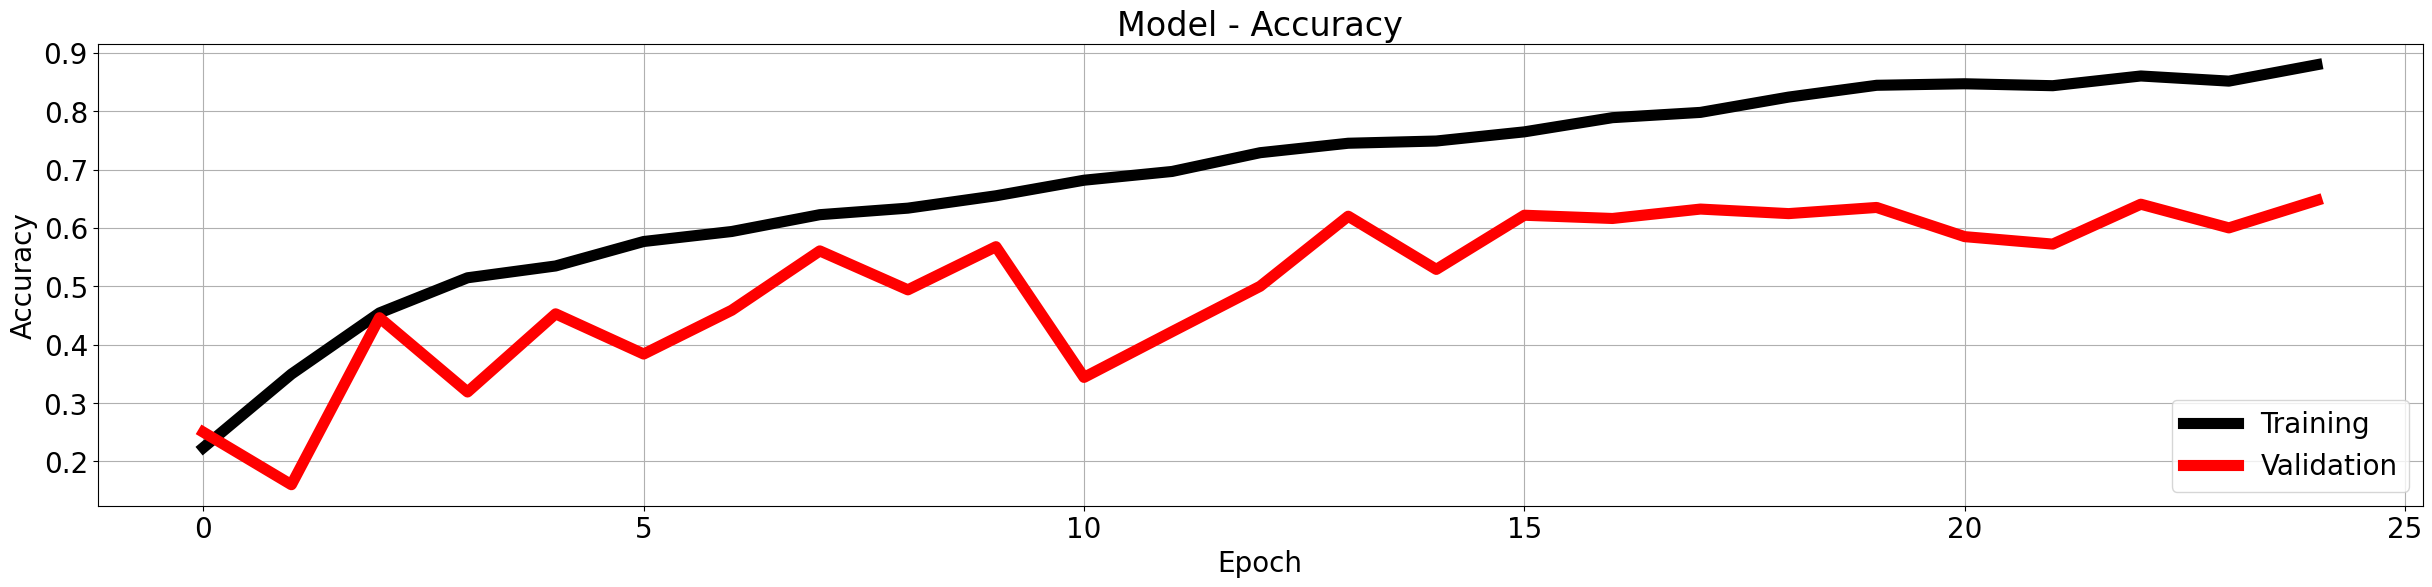

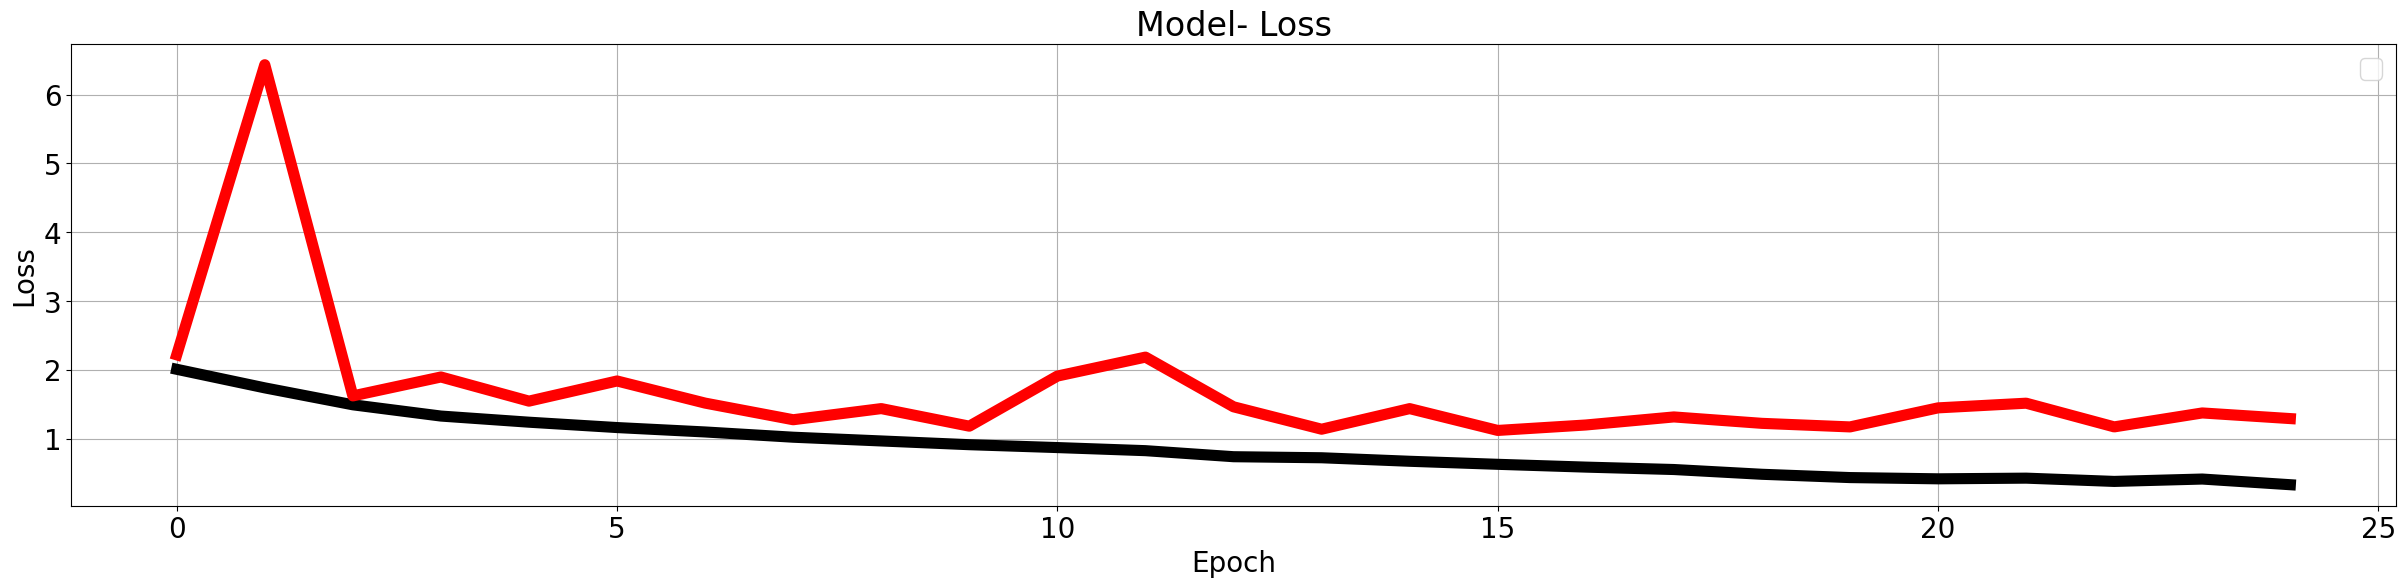

57/57 [==============================] - 1s 19ms/step


In [19]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['font.size'] = (20)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

evaluate_model(history,x_test_df, y_test_cat,cnn_model)
y_pred=cnn_model.predict(x_test_df)

              precision    recall  f1-score   support

           0     0.5192    0.6027    0.5579       224
           1     0.5735    0.3594    0.4419       217
           2     0.8290    0.6897    0.7529       232
           3     0.7854    0.8739    0.8273       222
           4     0.6114    0.5584    0.5837       231
           5     0.8249    0.6239    0.7105       234
           6     0.5613    0.8097    0.6630       226
           7     0.5600    0.6542    0.6034       214

    accuracy                         0.6472      1800
   macro avg     0.6581    0.6465    0.6426      1800
weighted avg     0.6602    0.6472    0.6440      1800



<Figure size 700x700 with 0 Axes>

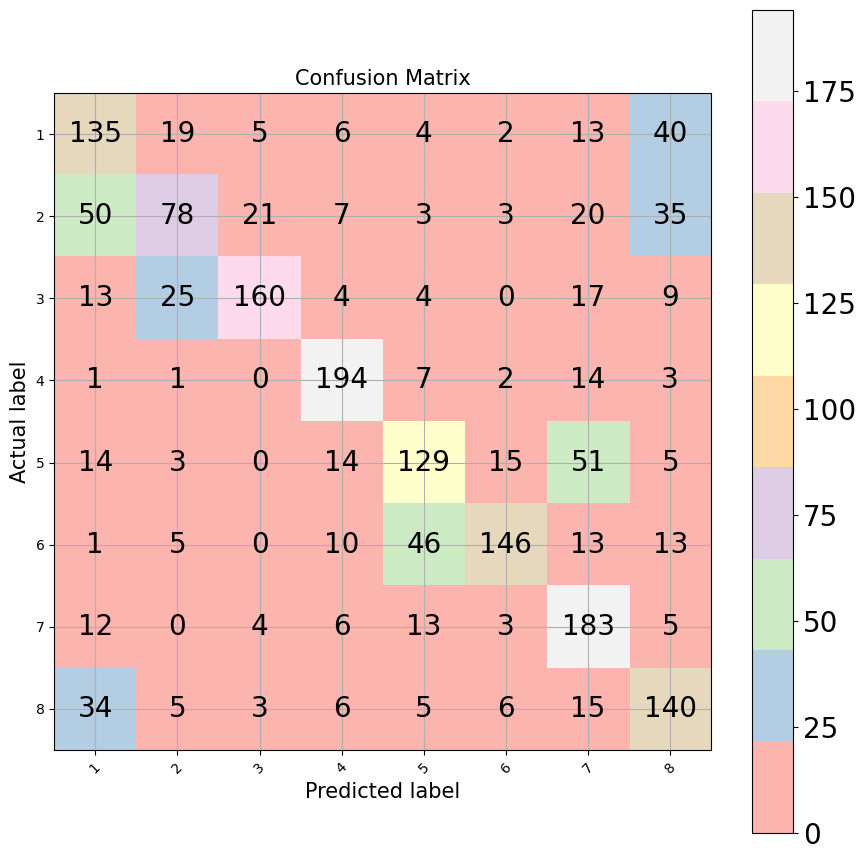

In [20]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_cat.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=4)

print(classification_report(y_test_cat.argmax(axis=1), y_pred.argmax(axis=1), digits=4))

# Plot non-normalized confusion matrix
plt.figure(figsize=(7, 7))
plot_confusion_matrix(cnf_matrix, title='Confusion Matrix')
plt.savefig('confusion_matrix.png', bbox_inches='tight')
plt.show()
